<a href="https://colab.research.google.com/github/BigRathna/actionDetection/blob/main/action_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running the collab doc continuously

In [ ]:
%%html
<audio src="https://oobabooga.github.io/silence.m4a" controls>

Downloading the dataset


In [ ]:
%%capture
!wget --no-check-certificate https://www.crcv.ucf.edu/datasets/human-actions/ucf101/UCF101.rar
!unrar x UCF101.rar

Streaming output truncated to the last 5000 lines.
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c05.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c06.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c07.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c01.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c02.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c03.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c04.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c05.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c06.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c07.avi             62%  OK 
Extracting  UCF-101/PlayingGu

In [ ]:
!pip install youtube-dl moviepy
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.5 MB/s eta 0:00:00
  Cloning https://github.com/TahaAnwar/pafy.git to /tmp/pip-install-hlc6ds2y/pafy_527063f1d1fa4396914828074059df46
  Running command git clone --filter=blob:none --quiet https://github.com/TahaAnwar/pafy.git /tmp/pip-install-hlc6ds2y/pafy_527063f1d1fa4396914828074059df46
  Resolved https://github.com/TahaAnwar/pafy.git to commit 2f3c473b3df7961721d07e1504675313afd1d2cb
  Preparing metadata (setup.py) ... done
  Created wheel for pafy: filename=pafy-0.5.5-py2.py3-none-any.whl size=35692 sha256=4dbdd7670800f8a4410fc66f2516fe1e031335834096b6dc30ec394324f6b548
  Stored in directory: /tmp/pip-ephem-wheel-cache-syhzaa7y/wheels/38/75/72/035d5f91837fe6fdd9ee6ec71eadaf7829068a58f4789a63cc
Successfully built pafy


In [ ]:
!python3 -m pip install --force-reinstall https://github.com/yt-dlp/yt-dlp/archive/master.tar.gz

In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import yt_dlp as youtube_dl

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 69
tf.random.set_seed(seed_constant)
np.random.seed(seed_constant)
random.seed(seed_constant)

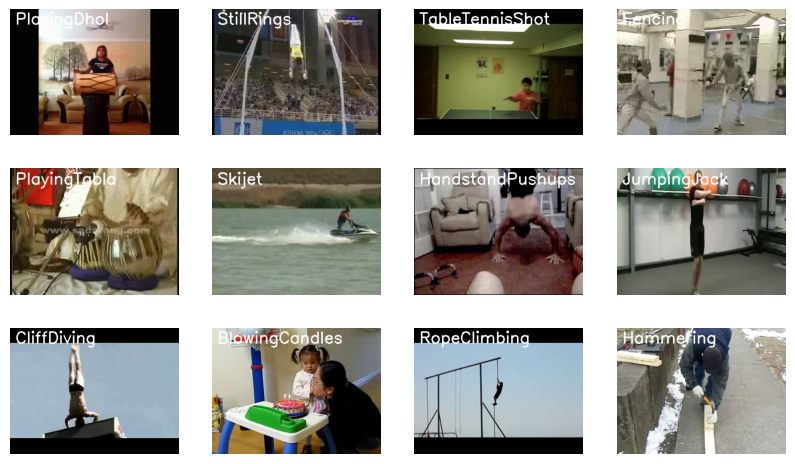

In [ ]:
# visualization

plt.figure(figsize = (10, 10))
all_classes_names = os.listdir('UCF-101')
random_range = random.sample(range(len(all_classes_names)), 12)

# showing random
for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'UCF-101/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'UCF-101/{selected_class_Name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

Preprocessing the videos

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 16

DATASET_DIR = "UCF-101"

#classes to train, add more to train
CLASSES_LIST = ["BlowDryHair","Bowling","BreastStroke","HorseRace","HammerThrow","Fencing","JumpingJack","Knitting","PlayingTabla","WritingOnBoard"]

In [ ]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)


    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

In [ ]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: BlowDryHair
Extracting Data of Class: Bowling
Extracting Data of Class: BreastStroke
Extracting Data of Class: HighJump
Extracting Data of Class: HammerThrow
Extracting Data of Class: MoppingFloor
Extracting Data of Class: JumpingJack
Extracting Data of Class: Knitting
Extracting Data of Class: PizzaTossing
Extracting Data of Class: Punch
Extracting Data of Class: PushUps
Extracting Data of Class: WritingOnBoard


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
# creating a cnn  + tcn model

def initialize_cust_model():
    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    # Replace LSTM with TCN
    model.add(Conv1D(64, 3, activation='relu', padding='causal'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 3, activation='relu', padding='causal'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, 3, activation='relu', padding='causal'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()

    return model


In [ ]:
TCN_model = initialize_cust_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 16, 4, 4, 32)     0

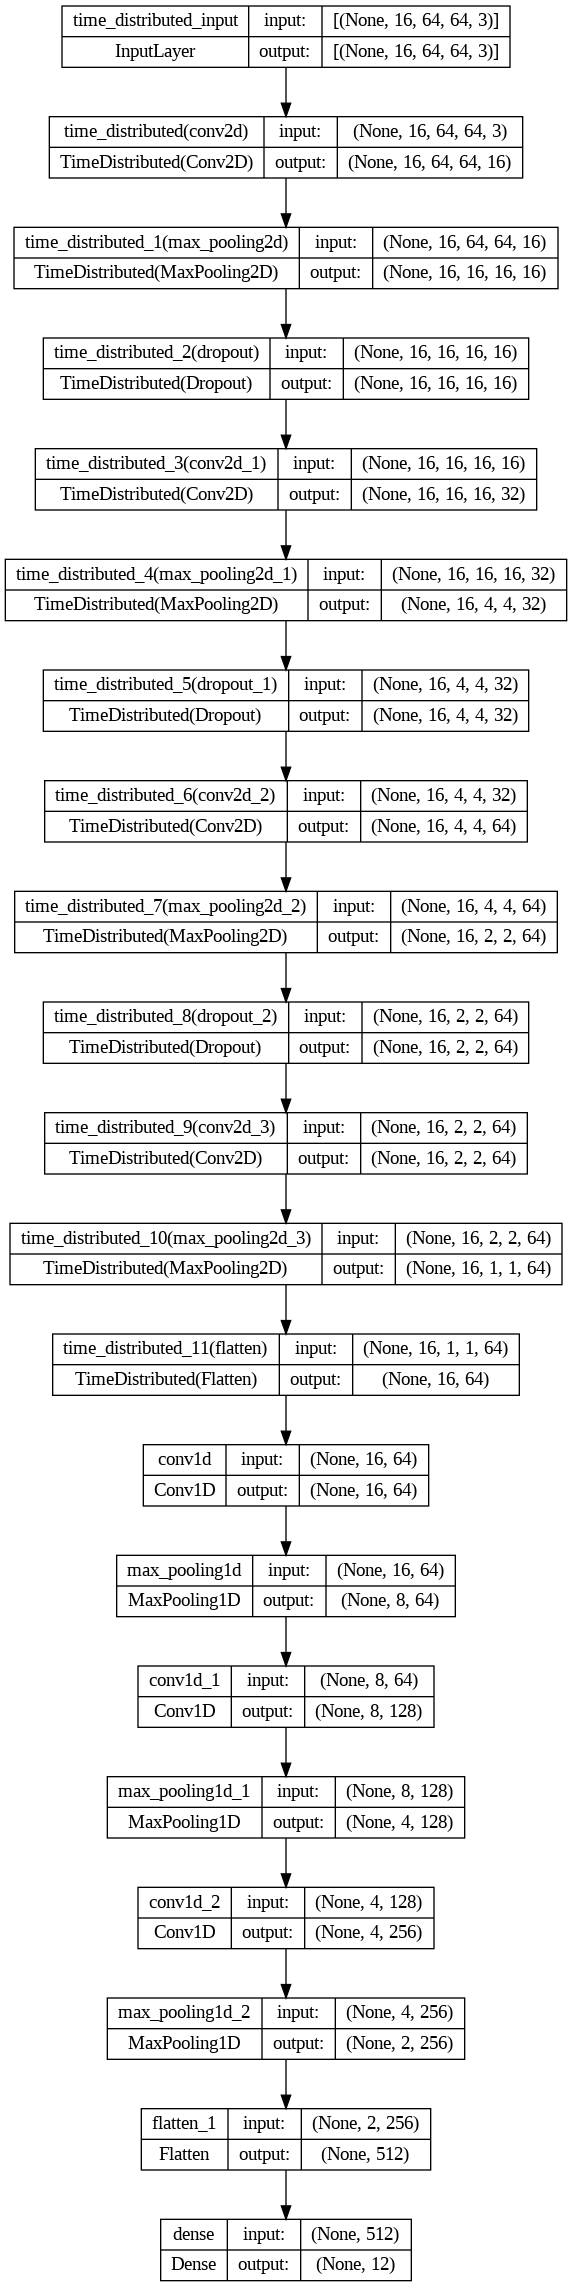

In [ ]:
plot_model(TCN_model, to_file = 'TCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
TCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
TCN_model_training_history = TCN_model.fit(x = features_train, y = labels_train, epochs = 128, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/128
232/232 [==============================] - 18s 16ms/step - loss: 2.4701 - accuracy: 0.0897 - val_loss: 2.4304 - val_accuracy: 0.1121
Epoch 2/128
232/232 [==============================] - 3s 12ms/step - loss: 2.3131 - accuracy: 0.1578 - val_loss: 2.3028 - val_accuracy: 0.2155
Epoch 3/128
232/232 [==============================] - 2s 10ms/step - loss: 2.2531 - accuracy: 0.1730 - val_loss: 2.2352 - val_accuracy: 0.2371
Epoch 4/128
232/232 [==============================] - 2s 9ms/step - loss: 2.0708 - accuracy: 0.2400 - val_loss: 1.9041 - val_accuracy: 0.3405
Epoch 5/128
232/232 [==============================] - 2s 10ms/step - loss: 1.8780 - accuracy: 0.3114 - val_loss: 2.0036 - val_accuracy: 0.3534
Epoch 6/128
232/232 [==============================] - 2s 10ms/step - loss: 1.7277 - accuracy: 0.3795 - val_loss: 1.8663 - val_accuracy: 0.4181
Epoch 7/128
232/232 [==============================] - 3s 14ms/step - loss: 1.6774 - accuracy: 0.3968 - val_loss: 1.6933 - val_accuracy:

In [ ]:
# Evaluate the trained model.
model_evaluation_history = TCN_model.evaluate(features_test, labels_test)

13/13 [==============================] - 1s 35ms/step - loss: 0.3120 - accuracy: 0.9352


saving the model

In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'TCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
TCN_model.save(model_file_name)

Plotting Model Accuracy and Loss

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

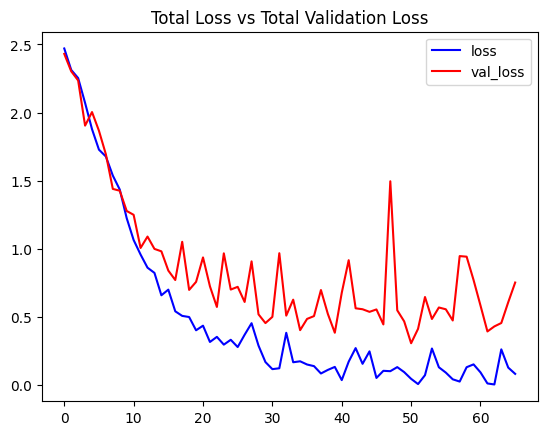

In [ ]:
plot_metric(TCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

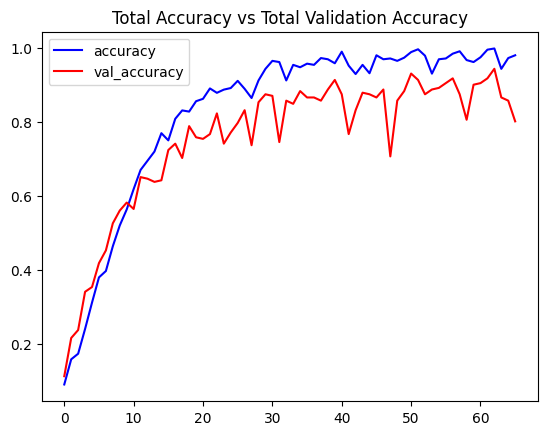

In [ ]:
plot_metric(TCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

TESTING ON NEW VIDEOS


In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
    ydl_opts = {
        'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
        'outtmpl': f'{output_directory}/%(title)s.%(ext)s',
        'ext' :'mp4',
        'prefer_ffmpeg': True
    }

    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        info_dict = ydl.extract_info(youtube_video_url, download=True)

    title = info_dict.get('title', None)
    return title


In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=p0jufcntchI', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

[youtube] Extracting URL: https://www.youtube.com/watch?v=p0jufcntchI
[youtube] p0jufcntchI: Downloading webpage
[youtube] p0jufcntchI: Downloading ios player API JSON
[youtube] p0jufcntchI: Downloading android player API JSON
[youtube] p0jufcntchI: Downloading m3u8 information
[youtube] p0jufcntchI: Downloading MPD manifest
[info] p0jufcntchI: Downloading 1 format(s): 136+140
[download] Destination: test_videos/Mopping.MP4.f136.mp4
[download] 100% of    9.30MiB in 00:00:00 at 35.93MiB/s  
[download] Destination: test_videos/Mopping.MP4.f140.m4a
[download] 100% of  529.64KiB in 00:00:00 at 7.27MiB/s   
[Merger] Merging formats into "test_videos/Mopping.MP4.mp4"
Deleting original file test_videos/Mopping.MP4.f140.m4a (pass -k to keep)
Deleting original file test_videos/Mopping.MP4.f136.mp4 (pass -k to keep)


In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):

    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            predicted_labels_probabilities = TCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [ ]:
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 28ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t: 100%|██████████| 1002/1002 [00:11<00:00, 132.28it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file test_videos/Mopping.MP4-Output-SeqLen16.mp4, 479700 bytes wanted but 0 bytes read,at frame 1001/1002, at time 33.37/33.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                                 

Moviepy - Done !
Moviepy - video ready __temp__.mp4
